In [76]:
from qiskit import Aer, execute, QuantumCircuit
from qiskit.quantum_info import Statevector, state_fidelity
from qiskit.circuit import ParameterVector
from qiskit.visualization import plot_histogram
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# Data Loading

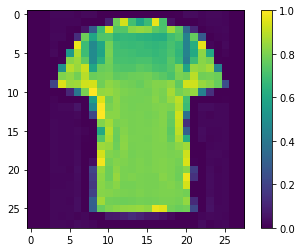

In [7]:
images=np.load('data/images.npy')
labels=np.load('data/labels.npy')
images = (images/0.00392156862745098)

test = 1
plt.imshow(images[test])
plt.colorbar()
plt.show()

# Part 1 - Encoding

Image before:
The shape of the images is: (2000, 28, 28)


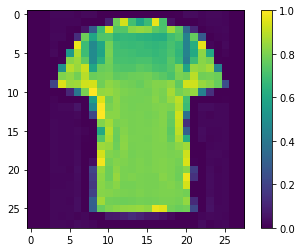

In [30]:
size = np.array([3,3])
area = size[0]*size[1]
Shots = 100000
select_image = 1

images2 = images
images2 = images2.reshape(images2.shape[0], *(28,28,1))

images2 = tf.image.resize(images2, (size[0],size[1])).numpy()

print("Image before:")
plt.imshow(images[select_image])
print("The shape of the images is: {}".format(images.shape))
plt.colorbar()
plt.show()

Image then:
The shape of the images is: (2000, 3, 3, 1)


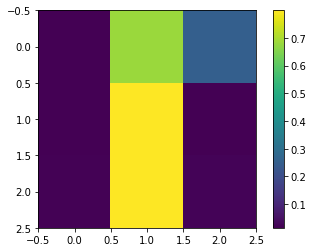

In [31]:
print("Image then:")
print("The shape of the images is: {}".format(images2.shape))
Real_values = images2[select_image]
plt.imshow(images2[select_image])
plt.colorbar()
plt.show()

In [32]:
images2 = images2.reshape(images2.shape[0], *(1,area,1))

# Encoding Function

In [33]:
def Encode(select_image, area):
    p = ParameterVector('p', area) 
    qc = QuantumCircuit(area)
    for i in range(area):
        qc.rx(p[i],i)
    # bind parameters
    for i in range(area):
        qc = qc.bind_parameters({p[i]:images2[select_image][0][i][0]})
    
    qc.measure_all()
    backend = Aer.get_backend('qasm_simulator')
    job = execute(qc, backend, shots=Shots)
    res = job.result().get_counts(qc)
    return res

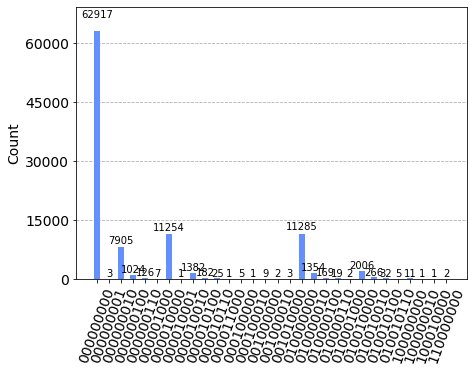

In [34]:
res = Encode(select_image, area)
plot_histogram(res)

# Part 2 - Decoding

In [81]:
def Decode(hist, area):
    keys = np.array(list(hist.keys()))
    for k in range(len(keys)):
        keys[k] = int(keys[k],2)
    keys = np.array(keys, dtype='int64')
    values = np.array(list(hist.values()))
    values = values/Shots
    new_dict = {keys[i]: values[i] for i in range(len(keys))}
    
    parameter_list = []
    
    parameter_list.append(2*np.arctan(np.sqrt(new_dict[1]/new_dict[0])))
    value = 1
    for j in range(area-1):
        value *= 2
        parameter_list.append(2*np.arctan(np.sqrt(new_dict[value]/new_dict[0])))
    
    parameter_list = np.array(parameter_list)
    parameter_list = parameter_list.reshape(size[0],size[1])
    
    return parameter_list

Image then:


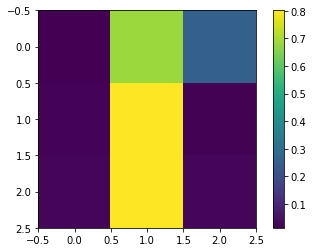

In [82]:
Dec = Decode(res, area)
print("Image then:")
plt.imshow(Dec)
plt.colorbar()
plt.show()

In [86]:
# Fidelity:
Real = Real_values.reshape(1,-1)[0]
Reconstrud = Dec.reshape(1,-1)[0]

1-mean_squared_error(Real, Reconstrud)

0.9999909608002511